In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import glob
import scipy.io as sio
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score

In [80]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [81]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [82]:
import urllib.request
import tarfile
import os

def download_and_extract_dataset():
    dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
    tgz_file = "BSR_bsds500.tgz"
    
    if not os.path.exists('BSR'):
        print("Downloading BSDS500 dataset...")
        urllib.request.urlretrieve(dataset_url, tgz_file)
        
        print("Extracting dataset...")
        with tarfile.open(tgz_file, 'r:gz') as tar:
            tar.extractall()
        print("Dataset extracted successfully!")

# Call the function to download and extract the dataset
download_and_extract_dataset()


In [83]:
# Define paths
data_dir = 'BSR/BSDS500/data'
images_dir = os.path.join(data_dir, 'images')
gt_dir = os.path.join(data_dir, 'groundTruth')

In [84]:
# Dataset class
class BSDS500Dataset(Dataset):
    def __init__(self, split='test', transform=None, target_size=(320, 320)):
        self.split = split
        self.transform = transform
        self.target_size = target_size
        self.img_paths = glob.glob(f'BSR/BSDS500/data/images/{split}/*.jpg')
        self.gt_paths = [p.replace('images', 'groundTruth').replace('.jpg', '.mat') 
                       for p in self.img_paths]
    
    def __len__(self): return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = cv2.resize(cv2.cvtColor(cv2.imread(self.img_paths[idx]), cv2.COLOR_BGR2RGB), self.target_size)
        gt_edges = np.sum([cv2.resize(sio.loadmat(self.gt_paths[idx])['groundTruth'][0,i]['Boundaries'][0,0].astype(np.float32), 
                                    self.target_size) for i in range(4)], axis=0)
        return transform(img) if self.transform else img, torch.from_numpy((gt_edges > 0).astype(np.float32)).unsqueeze(0)

In [85]:
# Define the Simple CNN Model 
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First conv layer: 3 input channels (RGB), 8 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        
        # Second conv layer: 8 input channels, 16 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        
        # Third conv layer: 16 input channels, 1 output channel (edge map), 3x3 kernel
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x


In [86]:
# Define the VGG16-based Edge Detection Model with transpose convolution
class VGG16EdgeDetection(nn.Module):
    def __init__(self, use_bilinear=False):
        super(VGG16EdgeDetection, self).__init__()
        
        # Load pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        
        # Get feature layers up to the last pooling layer (excluding it)
        features = list(vgg16.features.children())[:-1]
        self.features = nn.Sequential(*features)
        
        # Upsampling method: transpose convolution or bilinear interpolation
        self.use_bilinear = use_bilinear
        
        if not use_bilinear:
            # Transpose convolution to upsample feature maps back to original size
            # 512 -> 256
            self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.relu1 = nn.ReLU(inplace=True)
            
            # 256 -> 128
            self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.relu2 = nn.ReLU(inplace=True)
            
            # 128 -> 64
            self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.relu3 = nn.ReLU(inplace=True)
            
            # 64 -> 32
            self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
            self.relu4 = nn.ReLU(inplace=True)
        else:
            # Use convolutional layers after bilinear upsampling
            self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
            self.relu1 = nn.ReLU(inplace=True)
            
            self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
            self.relu2 = nn.ReLU(inplace=True)
            
            self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
            self.relu3 = nn.ReLU(inplace=True)
            
            self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
            self.relu4 = nn.ReLU(inplace=True)

        # Final convolution to output edge map
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Original input size for reference
        input_size = x.size()[2:]
        
        # Extract features using VGG16
        features = self.features(x)
        
        if not self.use_bilinear:
            # Upsample using transpose convolutions
            x = self.relu1(self.upconv1(features))
            x = self.relu2(self.upconv2(x))
            x = self.relu3(self.upconv3(x))
            x = self.relu4(self.upconv4(x))
        else:
            # Upsample using bilinear interpolation + conv
            x = self.relu1(self.conv1(features))
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            
            x = self.relu2(self.conv2(x))
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            
            x = self.relu3(self.conv3(x))
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            
            x = self.relu4(self.conv4(x))
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

        # Final adjustment to match input size exactly (if needed)
        if x.size()[2:] != input_size:
            x = nn.functional.interpolate(x, size=input_size, mode='bilinear', align_corners=True)
        
        # Final convolution and sigmoid to get edge probabilities
        x = self.sigmoid(self.final_conv(x))
        
        return x

In [87]:
class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()
        # Load pretrained VGG16 without fully connected layers
        vgg16 = models.vgg16(pretrained=True)
        
        # Extract features before each pooling layer (excluding the final pooling)
        # VGG16 structure: 2 conv -> pool -> 2 conv -> pool -> 3 conv -> pool -> 3 conv -> pool -> 3 conv -> pool
        features = list(vgg16.features.children())
        
        # Create feature extractors for each stage
        self.stage1 = nn.Sequential(*features[:4])   # Before first pooling
        self.stage2 = nn.Sequential(*features[4:9])  # Before second pooling
        self.stage3 = nn.Sequential(*features[9:16]) # Before third pooling
        self.stage4 = nn.Sequential(*features[16:23]) # Before fourth pooling
        self.stage5 = nn.Sequential(*features[23:30]) # Before fifth pooling (exclude final pooling)
        
        # Side output layers (1x1 convolutions)
        self.side1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side5 = nn.Conv2d(512, 1, kernel_size=1)
        
        # Fusion layer (learnable weights)
        self.fuse = nn.Conv2d(5, 1, kernel_size=1)
        
        # Initialize weights for side outputs and fusion
        self._initialize_weights()

    def _initialize_weights(self):
        for m in [self.side1, self.side2, self.side3, self.side4, self.side5, self.fuse]:
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Store original input size for upsampling
        input_size = x.size()[2:]
        
        # Forward pass through VGG stages
        stage1 = self.stage1(x)
        stage2 = self.stage2(stage1)
        stage3 = self.stage3(stage2)
        stage4 = self.stage4(stage3)
        stage5 = self.stage5(stage4)
        
        # Side outputs with upsampling to original size
        side1 = self.side1(stage1)
        side1 = F.interpolate(side1, size=input_size, mode='bilinear', align_corners=True)
        
        side2 = self.side2(stage2)
        side2 = F.interpolate(side2, size=input_size, mode='bilinear', align_corners=True)
        
        side3 = self.side3(stage3)
        side3 = F.interpolate(side3, size=input_size, mode='bilinear', align_corners=True)
        
        side4 = self.side4(stage4)
        side4 = F.interpolate(side4, size=input_size, mode='bilinear', align_corners=True)

        side5 = self.side5(stage5)
        side5 = F.interpolate(side5, size=input_size, mode='bilinear', align_corners=True)
        
        # Concatenate side outputs and apply fusion layer
        fused = torch.cat([side1, side2, side3, side4, side5], dim=1)
        fused = self.fuse(fused)
        
        # Return all outputs (side outputs and fused output)
        return [side1, side2, side3, side4, side5, fused]
    

In [88]:
# Apply Canny edge detection with different blurring parameters
def canny_edge_detection(img, low_threshold=50, high_threshold=150, sigma=1.0):
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Calculate kernel size based on sigma
    kernel_size = int(2 * np.ceil(3 * sigma) + 1)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma)
    
    # Run Canny edge detector
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    
    # Normalize to [0, 1]
    edges = edges / 255.0
    
    return edges

In [89]:
def load_models():
    models_dict = {}
    
    # Simple CNN
    models_dict['CNN'] = SimpleCNN().to(device)
    models_dict['CNN'].load_state_dict(torch.load('/kaggle/input/edge-detection/pytorch/default/1/simple_cnn_edge_detector.pth'))
    
    # VGG16 
    models_dict['VGG16'] = VGG16EdgeDetection().to(device)
    models_dict['VGG16'].load_state_dict(torch.load('/kaggle/input/edge-detection/pytorch/default/1/vgg16_edge_detector_100epochs.pth'))
    
    # HED
    models_dict['HED'] = HED().to(device)
    hed_checkpoint = torch.load('/kaggle/input/edge-detection/pytorch/default/1/best_hed_model.pth', map_location=device)
    models_dict['HED'].load_state_dict(hed_checkpoint['model_state_dict'])
    
    return models_dict

In [90]:
# Evaluation metrics
def calculate_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.float32)
    tp = np.sum(pred_bin * target)
    fp = np.sum(pred_bin * (1-target))
    fn = np.sum((1-pred_bin) * target)
    precision = tp/(tp+fp+1e-10)
    recall = tp/(tp+fn+1e-10)
    return precision, recall, 2*precision*recall/(precision+recall+1e-10)

In [110]:
def compare_all(models_dict, test_loader, num_images=4):
    dataiter = iter(test_loader)
    images, targets = next(dataiter)
    
    results = {'Canny': []}
    with torch.no_grad():
        for name, model in models_dict.items():
            if name == 'HED':
                outputs = model(images.to(device))[-1].sigmoid().cpu().numpy()
            elif name != 'Canny':
                outputs = model(images.to(device)).sigmoid().cpu().numpy()
            results[name] = outputs

    for i in range(num_images):
        plt.figure(figsize=(24, 5))
        
        # Original image
        plt.subplot(1,6,1)
        img = images[i].permute(1,2,0).numpy() * [0.229,0.224,0.225] + [0.485,0.456,0.406]
        plt.imshow(np.clip(img,0,1))
        plt.title('Original')
        plt.axis('off')

        # Ground truth
        plt.subplot(1,6,2)
        plt.imshow(targets[i,0], cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Model predictions
        for j, (model_name, preds) in enumerate(results.items()):
            if model_name == 'Canny': continue
            plt.subplot(1,6,3+j-1)
            if model_name == 'CNN': 
                plt.imshow((preds[i,0]).astype(float), cmap='gray')
            else: 
                plt.imshow((preds[i,0] > 0.5).astype(float), cmap='gray')
            
            plt.title(model_name)
            plt.axis('off')

        # Canny
        plt.subplot(1,6,6)
        img_np = images[i].cpu().permute(1,2,0).numpy()
        img_np = (img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        img_np = img_np.astype('uint8')
        edges = canny_edge_detection(img_np)
        results['Canny'].append(edges)
        plt.imshow(edges, cmap='gray')
        plt.title('Canny')
        plt.axis('off')

        plt.show()

<ipython-input-89-9ac600bac3eb>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_dict['CNN'].load_state_dict(torch.load('/kaggle/input/edge-detection/pytorch/default/

Visualizing comparisons...


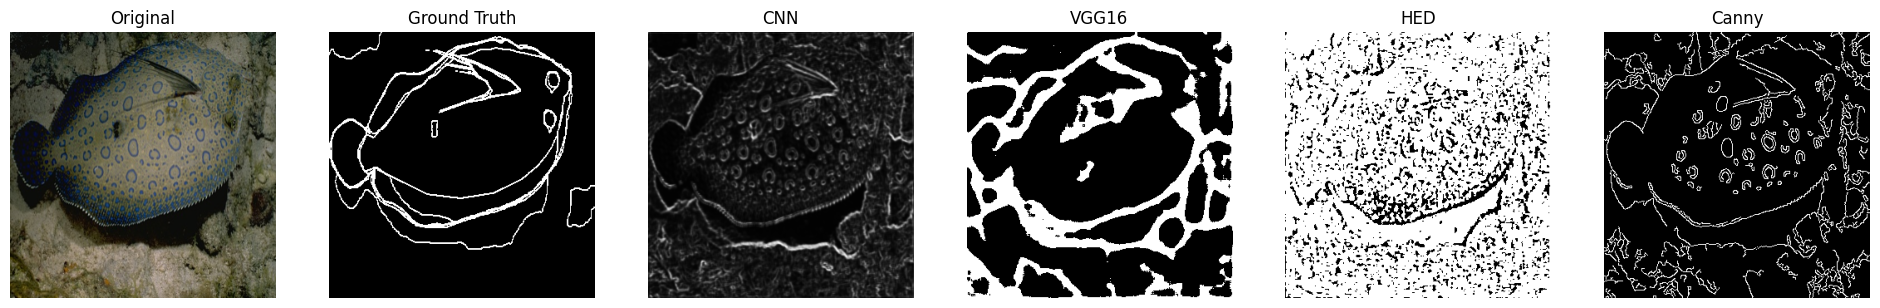

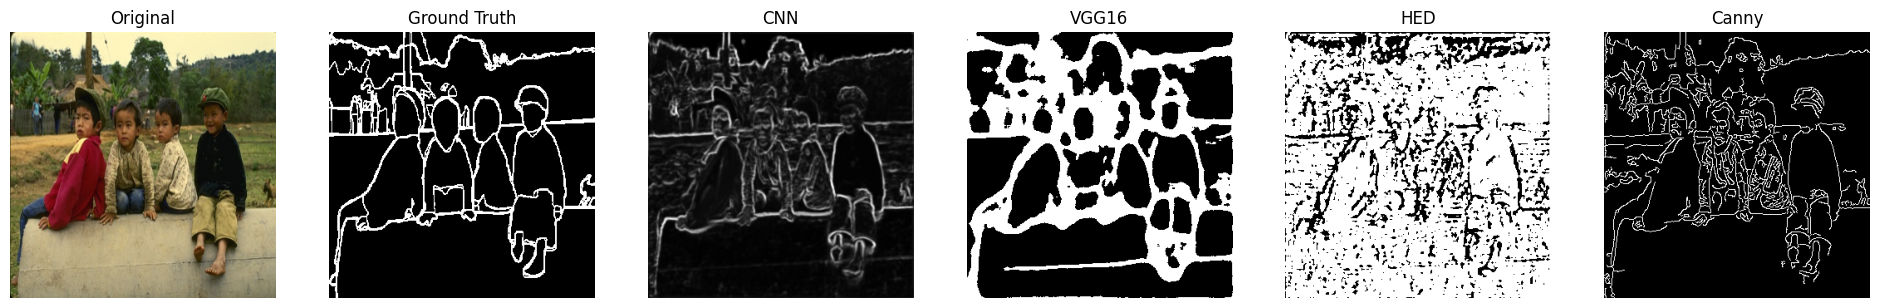

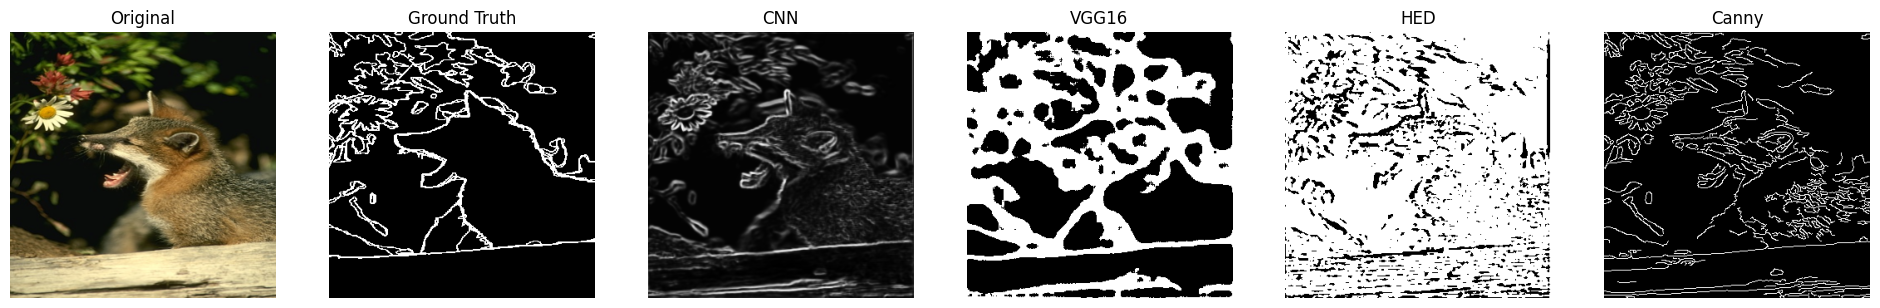

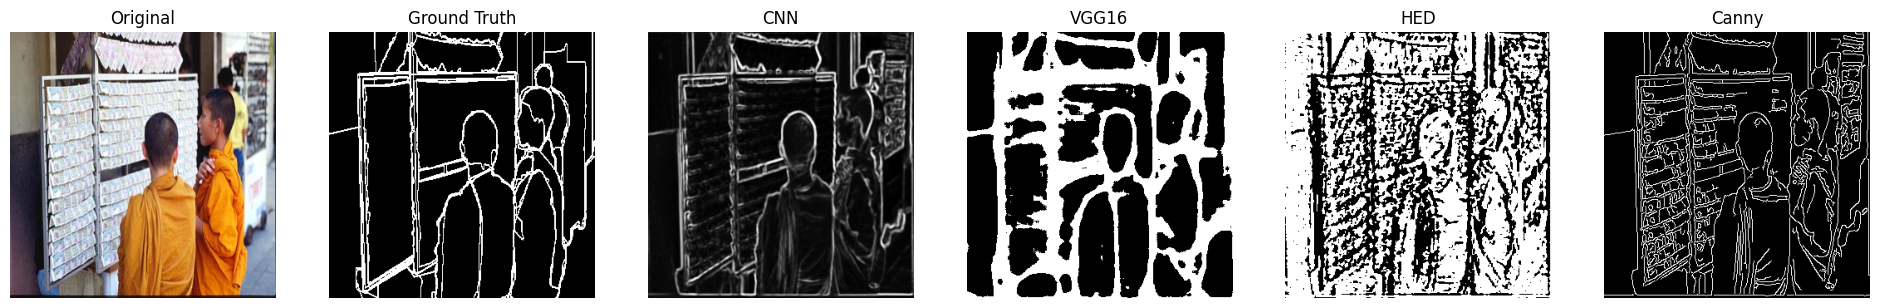


Quantitative Metrics:
       Precision    Recall  F1-Score
CNN     0.097347  1.000000  0.175830
VGG16   0.241982  0.841096  0.371135
HED     0.081753  0.663718  0.143595
Canny   0.267305  0.217969  0.225288


In [112]:
def main():
    models = load_models()
    test_dataset = BSDS500Dataset(split='test', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
    
    print("Visualizing comparisons...")
    compare_all(models, test_loader)
    
    print("\nQuantitative Metrics:")
    metrics = {}
    for name, model in models.items():
        if name == 'Canny': continue
        prec, rec, f1 = [], [], []
        for img, target in test_loader:
            with torch.no_grad():
                if name == 'HED':
                    pred = model(img.to(device))[-1].sigmoid().cpu().numpy()
                else:
                    pred = model(img.to(device)).sigmoid().cpu().numpy()
            for i in range(pred.shape[0]):
                p, r, f = calculate_metrics(pred[i,0], target[i,0].numpy())
                prec.append(p); rec.append(r); f1.append(f)
        metrics[name] = {
            'Precision': np.mean(prec),
            'Recall': np.mean(rec),
            'F1-Score': np.mean(f1)
        }

    # Add Canny metrics
    prec, rec, f1 = [], [], []
    for img, target in test_loader:
        img = img.permute(0,2,3,1).numpy() * [0.229,0.224,0.225] + [0.485,0.456,0.406]
        for i in range(img.shape[0]):
            rgb_image = (img[i] * 255).astype('uint8')
            gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
            pred = canny_edge_detection(gray)
            p, r, f = calculate_metrics(pred, target[i,0].numpy())
            prec.append(p); rec.append(r); f1.append(f)
    metrics['Canny'] = {
        'Precision': np.mean(prec),
        'Recall': np.mean(rec),
        'F1-Score': np.mean(f1)
    }

    print(pd.DataFrame(metrics).T)

if __name__ == "__main__":
    main()